<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#Анализ-данных" data-toc-modified-id="Анализ-данных-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ данных</a></span></li><li><span><a href="#Модель" data-toc-modified-id="Модель-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Модель</a></span></li><li><span><a href="#Чек-лист-готовности-проекта" data-toc-modified-id="Чек-лист-готовности-проекта-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Чек-лист готовности проекта</a></span></li></ul></div>

# Восстановление золота из руды

Цель: подготовить прототип модели машинного обучения дл компании, разрабатывающей решения для эффективной работы промышленных предприятий.

Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды. В проекте используются данные с параметрами добычи и очистки. 

Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

Задачи:

1. Подготовить данные;
2. Провести исследовательский анализ данных;
3. Построить и обучить модель.


## Подготовка данных


Подготовимся к выполнению задачи: импортируем функции и файлы, которые нам потребуются:

In [1]:
# импорт всего

import pandas as pd
from sklearn.metrics import mean_absolute_error

import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import make_scorer

from sklearn.utils import shuffle


In [4]:
data_train = pd.read_csv('gold_recovery_train_new.csv')
data_test = pd.read_csv('gold_recovery_test_new.csv')
data_full = pd.read_csv('gold_recovery_full_new.csv')

data_train.info()
data_test.info()
data_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14149 entries, 0 to 14148
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                14149 non-null  object 
 1   final.output.concentrate_ag                         14148 non-null  float64
 2   final.output.concentrate_pb                         14148 non-null  float64
 3   final.output.concentrate_sol                        13938 non-null  float64
 4   final.output.concentrate_au                         14149 non-null  float64
 5   final.output.recovery                               14149 non-null  float64
 6   final.output.tail_ag                                14149 non-null  float64
 7   final.output.tail_pb                                14049 non-null  float64
 8   final.output.tail_sol                               14144 non-null  float64


Видим пропуски во всех трех наборах данных, от них нужно будет избавиться

***
Проверим, что эффективность обогащения рассчитана правильно. Вычислим её на обучающей выборке для признака `rougher.output.recovery`. Найдем MAE между данными и нашими расчетами


In [7]:
C = data_train_check['rougher.output.concentrate_au']
F = data_train_check['rougher.input.feed_au']
T = data_train_check['rougher.output.tail_au']

recovery_t =data_train_check['rougher.output.recovery']

recovery = (C * (F - T)) / (F * (C - T)) * 100

# заменяем полученные в наборе бесконечности на ноль
recovery = recovery.replace([np.inf, -np.inf], 0)

# считаем среднюю абсолютную ошибку между величинами
MAE = (abs(recovery - recovery_t)).sum() / len (recovery)
MAE

9.82970122149377e-15

In [4]:
data_train['rougher.output.recovery'].describe()

count    14287.000000
mean        82.394201
std         15.096808
min          0.000000
25%         79.818372
50%         85.235997
75%         90.131691
max        100.000000
Name: rougher.output.recovery, dtype: float64

Получилось так, что в некоторых строчках у нас есть нули в столбцах, используемых при расчете c, f, t. Из-за этого мы получаем нан в наших столбцах и получаем ошибку при расчете mae, поэтому сбросим путстые строчки, но запишем данные без пропусков в новую переменную, позже сделаем обработку пропусков по-хорошему.

Значение MAE получилось приближенное к нулю, значит, все рассчитано верно

***
Проанализируем признаки, недоступные в тестовой выборке.

In [5]:
test_features_list = pd.Series(data_test.columns)
train_features_list = pd.Series(data_train.columns)

columns_difference = train_features_list[~train_features_list.isin(data_test.columns)]
columns_difference

1                           final.output.concentrate_ag
2                           final.output.concentrate_pb
3                          final.output.concentrate_sol
4                           final.output.concentrate_au
5                                 final.output.recovery
6                                  final.output.tail_ag
7                                  final.output.tail_pb
8                                 final.output.tail_sol
9                                  final.output.tail_au
14                primary_cleaner.output.concentrate_ag
15                primary_cleaner.output.concentrate_pb
16               primary_cleaner.output.concentrate_sol
17                primary_cleaner.output.concentrate_au
18                       primary_cleaner.output.tail_ag
19                       primary_cleaner.output.tail_pb
20                      primary_cleaner.output.tail_sol
21                       primary_cleaner.output.tail_au
30        rougher.calculation.sulfate_to_au_conc

В тестовой выборке нет параметров продукта и расчетных характеристик, что логично, ведь остались только те вводные данные, которые в будущем будут доступны нашей модели в работе

***
Проведем предобработку данных

В предыдущем шаге мы избавились от пропуков, чтобы посчитать MAE без ошибок, но сейчас сделаем это по-другому: так как наши признаки, которые находятся рядом с точки зрения времени, должны быть похожи (условие задачи), мы воспользуемся этим и заполним пропуски стоящими рядом значениями, предварительно отсортировав данные в хронологическом порядке. Дополнительно перемешаем данные после заполнения пропусков, чтобы обучение модели прошло корректно

In [7]:
# заполнить пропуски 

data_train = data_train.sort_values('date', ascending=True)
data_train = data_train.fillna(method='ffill')
data_train = shuffle(data_train)

data_full = data_full.sort_values('date', ascending=True)
data_full = data_full.fillna(method='ffill')
data_full = shuffle(data_full)

data_test = data_test.sort_values('date', ascending=True)
data_test = data_test.fillna(method='ffill')
data_test = shuffle(data_test)

#проверка
data_full.describe()
data_train.describe()
data_test.info()
data_test


<class 'pandas.core.frame.DataFrame'>
Int64Index: 5856 entries, 4160 to 2579
Data columns (total 53 columns):
date                                          5856 non-null object
primary_cleaner.input.sulfate                 5856 non-null float64
primary_cleaner.input.depressant              5856 non-null float64
primary_cleaner.input.feed_size               5856 non-null float64
primary_cleaner.input.xanthate                5856 non-null float64
primary_cleaner.state.floatbank8_a_air        5856 non-null float64
primary_cleaner.state.floatbank8_a_level      5856 non-null float64
primary_cleaner.state.floatbank8_b_air        5856 non-null float64
primary_cleaner.state.floatbank8_b_level      5856 non-null float64
primary_cleaner.state.floatbank8_c_air        5856 non-null float64
primary_cleaner.state.floatbank8_c_level      5856 non-null float64
primary_cleaner.state.floatbank8_d_air        5856 non-null float64
primary_cleaner.state.floatbank8_d_level      5856 non-null float64
rougher

,date,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
4160,2017-10-22 08:59:59,233.047967,14.045152,7.050000,2.404450,1699.864545,-497.708037,1698.467574,-515.430094,1641.429062,...,20.987599,-501.466120,19.016755,-400.343467,14.944931,-501.611693,11.023029,-500.139020,15.982587,-500.260431
1934,2016-11-20 14:59:59,224.826588,7.693786,7.550000,1.096241,1609.489930,-499.664547,1620.136944,-499.988796,1639.906385,...,18.000099,-499.084044,16.018738,-498.707175,15.259062,-499.104204,11.987233,-499.780680,5.054503,-809.601822
1790,2016-11-14 14:59:59,221.732738,8.684621,7.160000,0.945199,1596.039863,-500.679427,1601.048421,-500.211949,1598.080722,...,15.971493,-501.032805,13.984239,-502.369591,14.882311,-501.346112,14.022224,-500.334287,22.003192,-503.541797
88,2016-09-04 16:59:59,141.612716,8.041522,7.926000,0.602837,1300.873401,-499.688782,1298.115355,-499.947239,1295.410874,...,11.984089,-500.483372,7.912583,-500.099095,7.964873,-501.502604,5.048417,-499.662707,9.930273,-500.631967
5128,2017-12-01 16:59:59,210.541340,7.992844,7.600000,2.187348,1591.459410,-499.230129,1589.577867,-500.032589,1590.346976,...,16.990442,-498.042015,15.019247,-369.983268,10.965944,-498.969311,9.002700,-500.438135,23.000992,-499.184690
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5433,2017-12-14 09:59:59,171.357707,9.985216,8.180000,1.101069,1552.930125,-500.152507,1544.562965,-501.159391,1545.667621,...,20.007780,-502.753290,14.954444,-134.883762,10.986849,-500.741492,8.073596,-500.012259,12.003243,-501.448298
5006,2017-11-26 14:59:59,208.616145,10.991142,7.450000,2.095457,1574.290495,-499.725111,1575.379050,-500.140702,1573.856784,...,17.014426,-500.942136,14.974570,-500.046019,10.933889,-500.305439,9.040937,-500.496074,16.001742,-500.397955
4113,2017-10-20 09:59:59,232.285446,13.981787,7.230000,2.071378,1698.396565,-499.728516,1700.022983,-497.212839,1652.819552,...,21.014386,-500.463104,19.044432,-399.952554,15.026910,-500.817995,10.998008,-499.971586,15.995090,-500.502223
3906,2017-10-11 18:59:59,141.428335,5.974690,6.510000,2.199644,1396.692167,-500.107449,1396.129359,-500.414213,1401.143174,...,17.998528,-500.032752,16.059521,-399.528803,12.915118,-500.031132,10.003872,-499.849710,14.023678,-499.806453


Готово! У нас остались столбцы, которые нам не понадобятся для обучения модели, но мы их удалим чуть позже

## Анализ данных

Посмотрим, как меняется концентрация металлов (*Au, Ag, Pb*) на различных этапах очистки: сделаем график. Перед этим необходимо посчитать непосредственно доли на каждом этапе (у нас их четыре).


In [8]:
# доля перед флотацией - 1
# доля перед первой чисткой - 2
# доля перед второй чисткой - 3 
# доля в финальном концентрате -4

def metal_share(au_volume, ag_volume, pb_volume):
    volume_sum = au_volume + ag_volume + pb_volume
    au_share = au_volume / volume_sum
    ag_share = ag_volume / volume_sum
    pb_share = pb_volume / volume_sum
    return au_share, ag_share, pb_share, volume_sum

data_full['share1_au'], data_full['share1_ag'], data_full['share1_pb'], data_full['sum_volume1']  = metal_share(data_full['rougher.input.feed_au'], data_full['rougher.input.feed_ag'], data_full['rougher.input.feed_pb'])
data_full['share2_au'], data_full['share2_ag'], data_full['share2_pb'], data_full['sum_volume2']  = metal_share(data_full['rougher.output.concentrate_au'], data_full['rougher.output.concentrate_ag'], data_full['rougher.output.concentrate_pb'])
data_full['share3_au'], data_full['share3_ag'], data_full['share3_pb'], data_full['sum_volume3']  = metal_share(data_full['primary_cleaner.output.concentrate_au'], data_full['primary_cleaner.output.concentrate_ag'], data_full['primary_cleaner.output.concentrate_pb'])
data_full['share4_au'], data_full['share4_ag'], data_full['share4_pb'], data_full['sum_volume4']  = metal_share(data_full['final.output.concentrate_au'], data_full['final.output.concentrate_ag'], data_full['final.output.concentrate_pb'])

data_full.describe()


,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,...,share2_pb,sum_volume2,share3_au,share3_ag,share3_pb,sum_volume3,share4_au,share4_ag,share4_pb,sum_volume4
count,22716.000000,22716.000000,22716.000000,22716.000000,22716.000000,22716.000000,22716.000000,22716.000000,22716.000000,22716.000000,...,20707.000000,22716.000000,21034.000000,21034.000000,21034.000000,22716.000000,21045.000000,21045.000000,21045.000000,22716.000000
mean,4.768013,9.071366,8.537502,39.891718,66.475263,8.900622,2.471149,9.434396,2.819885,131.338303,...,0.197663,35.563988,0.631287,0.173102,0.195611,45.596156,0.733222,0.094388,0.172390,53.731097
std,2.042594,3.260960,3.858203,13.540157,13.042781,3.544045,1.201069,4.145832,1.269214,58.477466,...,0.041132,13.333254,0.075959,0.044657,0.049064,16.164658,0.067840,0.043236,0.033083,17.898033
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000003,...,0.019300,0.000000,0.175157,0.028096,0.000000,0.000000,0.074721,0.000000,0.069614,0.000000
25%,4.011471,8.737809,7.036629,42.353890,62.258453,7.669323,1.780344,8.050901,2.297002,101.198976,...,0.169722,37.352316,0.598252,0.142257,0.174104,48.808485,0.724260,0.071823,0.154372,58.690559
50%,4.949959,9.910363,8.858385,44.639019,67.981407,9.477554,2.643964,10.174399,2.910336,137.084713,...,0.195962,39.970096,0.633494,0.168431,0.197705,51.525881,0.744344,0.085987,0.169429,60.073814
75%,5.857985,10.927188,10.667178,46.106662,72.941119,11.084153,3.282285,11.840024,3.552452,170.993920,...,0.214454,42.192985,0.668237,0.196089,0.220757,53.160929,0.762039,0.101734,0.185276,60.990602
max,16.001945,17.031899,19.615720,53.611374,100.000000,19.552149,6.086532,22.861749,9.789625,274.409626,...,0.437353,55.568687,0.913476,0.396634,0.787415,60.269003,0.854017,0.442750,0.526766,65.575259


Посчитали доли, теперь построим графики распределения долей маталлов по этапам, для этого сформируем таблицу, возьмем среднее значение по каждому металлу. 

 На будущее также сделали столбы суммарной концентрацией металлов на каждом этапе

In [9]:
# сформируем тадблицу для создания графика

import numpy as np

metals_by_steps = {'rougher' : [data_full['share1_au'].mean(), data_full['share1_ag'].mean(), data_full['share1_pb'].mean()],
                              'primary_cleaner' : [data_full['share2_au'].mean(), data_full['share2_ag'].mean(), data_full['share2_pb'].mean()],
                              'seconadary_cleaner' : [data_full['share3_au'].mean(), data_full['share3_ag'].mean(), data_full['share3_pb'].mean()],
                              'final' : [data_full['share4_au'].mean(), data_full['share4_ag'].mean(), data_full['share4_pb'].mean()]
        }
metals_by_steps = pd.DataFrame(metals_by_steps, index = ['au', 'ag', 'pb'])
metals_by_steps.T
#'primary cleaner', 'secondary cleaner', 'final'

,au,ag,pb
rougher,0.396703,0.426974,0.176322
primary_cleaner,0.497449,0.304888,0.197663
seconadary_cleaner,0.631287,0.173102,0.195611
final,0.733222,0.094388,0.172390


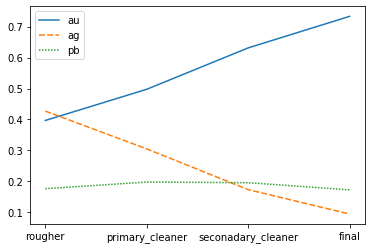

In [10]:
# теперь рисуем графики

sns.lineplot(data=metals_by_steps.T, sort= False)


На графике видим вполне ожидаемый результат: так как мы добываем золото, в финальном продукте будет его больше всего. 

***
Сравним распределения размеров гранул сырья на обучающей и тестовой выборках. Если распределения сильно отличаются друг от друга, оценка модели будет неправильной.


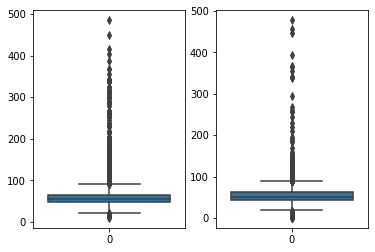

In [11]:
# делаем два боксплота

fig, ax =plt.subplots(1,2)

sns.boxplot(data=data_train['rougher.input.feed_size'], ax=ax[0])
sns.boxplot(data=data_test['rougher.input.feed_size'], ax=ax[1])

fig.show()

Здесь все ок! Продолжаем

***
Исследуем суммарную концентрацию всех веществ на разных стадиях: в сырье, в черновом и финальном концентратах.

In [12]:
# напоминание, о нумерации этапов
# доля перед флотацией - 1
# доля перед первой чисткой - 2
# доля перед второй чисткой - 3 
# доля в финальном концентрате -4


# df суммарными значениями
sums = data_full[['sum_volume1', 'sum_volume2', 'sum_volume3', 'sum_volume4']] 

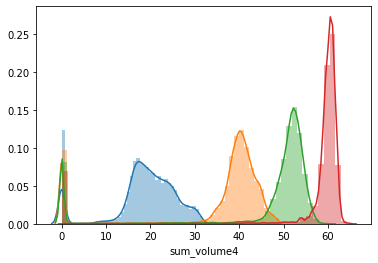

In [13]:
# гистограммы
sums_list = [data_full['sum_volume1'], data_full['sum_volume2'], data_full['sum_volume3'], data_full['sum_volume4']]

for i in sums_list:
    sns.distplot(i)
    

На графике видим, что есть пики в нулевых значениях - это аномалии, от них нужно избавиться

 По логике, если мы удалим нулевые импуты, нулевые аутпуты должны уйти сами, проверим:

In [14]:
data_full = data_full.drop(data_full[(data_full['rougher.input.feed_au'] == 0) 
                                     & (data_full['rougher.input.feed_ag'] == 0) 
                                     & (data_full['rougher.input.feed_pb'] == 0) 
                                     & (data_full['rougher.output.concentrate_au'] == 0)
                                     & (data_full['rougher.output.concentrate_ag'] == 0)
                                     & (data_full['rougher.output.concentrate_pb'] == 0)
                                     & (data_full['primary_cleaner.output.concentrate_au'] == 0)
                                     & (data_full['primary_cleaner.output.concentrate_ag'] == 0)
                                     & (data_full['primary_cleaner.output.concentrate_pb'] == 0)
                                     & (data_full['final.output.concentrate_au'] == 0)
                                     & (data_full['final.output.concentrate_ag'] == 0)
                                     & (data_full['final.output.concentrate_pb'] == 0)].index)


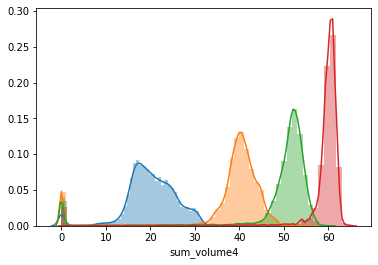

In [15]:
# проверка 

sums_list = [data_full['sum_volume1'], data_full['sum_volume2'], data_full['sum_volume3'], data_full['sum_volume4']]

for i in sums_list:
    sns.distplot(i)
    

In [16]:
data_train = data_train.drop(data_train[(data_train['rougher.input.feed_au'] == 0) 
                                     & (data_train['rougher.input.feed_ag'] == 0) 
                                     & (data_train['rougher.input.feed_pb'] == 0) 
                                     & (data_train['rougher.output.concentrate_au'] == 0)
                                     & (data_train['rougher.output.concentrate_ag'] == 0)
                                     & (data_train['rougher.output.concentrate_pb'] == 0)
                                     & (data_train['primary_cleaner.output.concentrate_au'] == 0)
                                     & (data_train['primary_cleaner.output.concentrate_ag'] == 0)
                                     & (data_train['primary_cleaner.output.concentrate_pb'] == 0)
                                     & (data_train['final.output.concentrate_au'] == 0)
                                     & (data_train['final.output.concentrate_ag'] == 0)
                                     & (data_train['final.output.concentrate_pb'] == 0)].index)


In [17]:
data_full = data_full.drop(data_full[(data_full['rougher.input.feed_au'] == 0) 
                                     & (data_full['rougher.input.feed_ag'] == 0) 
                                     & (data_full['rougher.input.feed_pb'] == 0)].index)


## Модель

Приступим непосредественно к главной цели проект - созданию модели.

 Напишем функцию для вычисления итоговой sMAPE:


In [18]:

def smape(target, predictions): 
    return np.sum(np.abs(target - predictions) / ((np.abs(target) + np.abs(predictions)) / 2)) / len(target) * 100
                  
def weighted_smape(target, predictions):
    return 0.25 * smape(target['rougher.output.recovery'], predictions[:, 0]) + 0.75 * smape(target['final.output.recovery'], predictions[:, 1])

Обучим разные модели и оценим их качество кросс-валидацией. Выберем лучшую модель и проверим её на тестовой выборке.

In [19]:
# разделим выборку на признаки и целевой

target_train = data_train[['rougher.output.recovery', 'final.output.recovery']]
features_train = data_train.drop(np.array(columns_difference), axis=1)

features_train = features_train.drop('date', axis=1)

# проверка
features_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15760 entries, 4907 to 12971
Data columns (total 52 columns):
primary_cleaner.input.sulfate                 15760 non-null float64
primary_cleaner.input.depressant              15760 non-null float64
primary_cleaner.input.feed_size               15760 non-null float64
primary_cleaner.input.xanthate                15760 non-null float64
primary_cleaner.state.floatbank8_a_air        15760 non-null float64
primary_cleaner.state.floatbank8_a_level      15760 non-null float64
primary_cleaner.state.floatbank8_b_air        15760 non-null float64
primary_cleaner.state.floatbank8_b_level      15760 non-null float64
primary_cleaner.state.floatbank8_c_air        15760 non-null float64
primary_cleaner.state.floatbank8_c_level      15760 non-null float64
primary_cleaner.state.floatbank8_d_air        15760 non-null float64
primary_cleaner.state.floatbank8_d_level      15760 non-null float64
rougher.input.feed_ag                         15760 non-null

In [68]:
# стандартизируем признаки 

scaler = StandardScaler()
scaler.fit(features_train)

features_train = scaler.transform(features_train)


Данные готовы, теперь можно переходить к моделям:

In [69]:
# дерево

best_score_tree = 5000
best_model_tree = None

for depth in range(1, 11):
    model_tree = DecisionTreeRegressor(random_state=44, max_depth = depth)
    scores = cross_val_score(model_tree, features_train, target_train, cv=5, scoring=make_scorer(weighted_smape))
    mean_score = scores.mean()
    if mean_score < best_score_tree:
        best_score_tree = mean_score
        best_model_tree = model_tree
        best_depth_tree = depth

print('Лучшее дерево')
print('средний sMAPE = ', best_score_tree, 'при глубине:', best_depth_tree)

Лучшее дерево
средний sMAPE =  10.044305797465757 при глубине: 10


In [70]:
# лес

best_score_forest = 5000
best_model_forest = None

for depth in range(1, 11):
    model_forest = RandomForestRegressor(random_state=44, n_estimators = 5, max_depth = depth)
    scores = cross_val_score(model_forest, features_train, target_train, cv=5, scoring=make_scorer(weighted_smape))
    mean_score = scores.mean()
    if mean_score < best_score_forest:
        best_score_forest = mean_score
        best_model_forest = model_forest
        best_depth_forest = depth

print('Лучший лес')
print('средний sMAPE = ', best_score_forest, 'N деревьев: 5', 'при глубине:', best_depth_forest)
print('___________________________________________________________')

best_score_forest = 5000
best_model_forest = None

for depth in range(1, 11):
    model_forest = RandomForestRegressor(random_state=44, n_estimators = 10, max_depth = depth)
    scores = cross_val_score(model_forest, features_train, target_train, cv=5, scoring=make_scorer(weighted_smape))
    mean_score = scores.mean()
    if mean_score < best_score_forest:
        best_score_forest = mean_score
        best_model_forest = model_forest
        best_depth_forest = depth

print('Лучший лес')
print('средний sMAPE = ', best_score_forest, 'N деревьев: 10', 'при глубине:', best_depth_forest)

Лучший лес
средний sMAPE =  10.035750428300378 N деревьев: 5 при глубине: 10
___________________________________________________________
Лучший лес
средний sMAPE =  10.066147317079732 N деревьев: 10 при глубине: 10


In [71]:
# регрессия

model_reg = LinearRegression()
scores = cross_val_score(model_reg, features_train, target_train, cv=5, scoring=make_scorer(weighted_smape))
mean_score_reg = scores.mean()

print('Линейная регрессия')
print('средний sMAPE = ', mean_score_reg)

Линейная регрессия
средний sMAPE =  12.129476985130903


Лучше всего показал себя случайный лес с 10 деревьями и глубиной 1, проверим его на тестовой выборке, но сначала ее нужно подготовить:

In [21]:
# удалим столб с датой, чтобы не мешал

data_test = data_test.drop('date', axis=1)

# сделаем target_test
target_test_rougher = data_full.loc[data_test.index, 'rougher.output.recovery']
target_test_final = data_full.loc[data_test.index, 'final.output.recovery']
target_test = pd.concat([target_test_rougher, target_test_final], axis=1)

# проверка
target_test


/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:961: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return getattr(section, self.name)[new_key]


,rougher.output.recovery,final.output.recovery
4160,59.447247,0.000000
1934,NaN,NaN
1790,NaN,NaN
88,58.300095,43.677458
5128,82.849002,71.677191
...,...,...
5433,75.847298,52.249493
5006,85.741308,73.066395
4113,NaN,NaN
3906,77.520638,67.440337


Теперь проверим

In [73]:
# проверка на тесте

final_model = RandomForestRegressor(random_state=44, n_estimators= 10, max_depth = 1)
final_model.fit(features_train, target_train)
predictions_test = final_model.predict(data_test)
final_smape = weighted_smape(target_test, predictions_test)

print('Итоговый sMAPE:', final_smape)

Итоговый sMAPE: 11.967843460208364


Сравним нашу модель с константной:

In [22]:
constant_r = pd.Series(target_train['rougher.output.recovery'].median(), index=target_test.index)
constant_f = pd.Series(target_train['final.output.recovery'].median(), index=target_test.index)
constant = pd.concat([constant_r, constant_f], axis=1)
constant = constant.to_numpy()

constant_smape = weighted_smape(target_test, constant)
constant_smape

12.073984538074479

Не на много, но наша модель показала себя лучше, значит, имеет право на существование